# DS4400 Final Project
### Kevin Lee, Karen Phung, Ethan van Heerden

**Final Project Guidelines**

Project Evaluation Guidelines:

Final class projects should answer the following questions. Include relevant information and data to support your design / modeling decisions. If there are other domain or dataset related details which have influenced your design include specific details and conclusions.

- What question is being answered? **(Karen + intro)**
  - What is the target – categorical / continuous / group-id (for unsupervised datasets)

- What techniques are being used for modeling? **(Kevin)**
  - Is there a progression from high bias to low bias models?
  - Are justifications provided for using specific models?

- Complexity of the dataset: **(Ethan)**
  - Are raw features used or is feature engineering applied?
  - How is the dimensionality of the dataset handled?

- End-to-end implementation of the prediction pipeline: **(ALL)**
  - Ethan: Decision Tree
  - Karen: Perceptron
  - Kevin: Logistic Regression
  - Implementation done completely with pre-processing
  - No leakage between training / test sets

- Evaluation strategies **(ALL)**:
  - Ethan: Decision Tree
  - Karen: Perceptron
  - Kevin: Logistic Regression
  - Correct evaluation methodology used for evaluation that reflects dataset nuances

- What metrics are used for tuning models **(ALL)**
  - Ethan: Decision Tree
  - Karen: Perceptron
  - Kevin: Logistic Regression
  - Correct metric selection for hyperparameter tuning

- Visualization of results: **(ALL)**
  - Ethan: Decision Tree
  - Karen: Perceptron
  - Kevin: Logistic Regression
  - Charts reflecting model performance
  - All relevant metrics visualized during training and testing

- Model Interpretation: **(Ethan + conclusion)**
  - Does the model provide any Insights about the domain / dataset?

In [61]:
# Imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore')

### The Dataset and Preprocessing

The data contains a mixture of numeric, categorical, and binary features that we will preprocess into all numeric data. We will also scale the already-numeric features with a `StandardScaler`. All of these preprocessing steps will be encapsulated in a `ColumnTransformer` which will be included in the training/testing pipeline for each of our models.


In [62]:
autism_screening = pd.read_csv("autism_screening.csv")

# Note: the researchers mispelled autism in their dataset
X = autism_screening.drop("Class/ASD", axis=1) # Drop the predicted y column
X = X.drop("austim", axis=1) # Drop the actual y column
y = autism_screening["austim"]

print(X)
print(y)

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0           1         1         1         1         0         0         1   
1           1         1         0         1         0         0         0   
2           1         1         0         1         1         0         1   
3           1         1         0         1         0         0         1   
4           1         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
699         0         1         0         1         1         0         1   
700         1         0         0         0         0         0         0   
701         1         0         1         1         1         0         1   
702         1         0         0         1         1         0         1   
703         1         0         1         1         1         0         1   

     A8_Score  A9_Score  A10_Score   age gender       ethnicity jundice  \


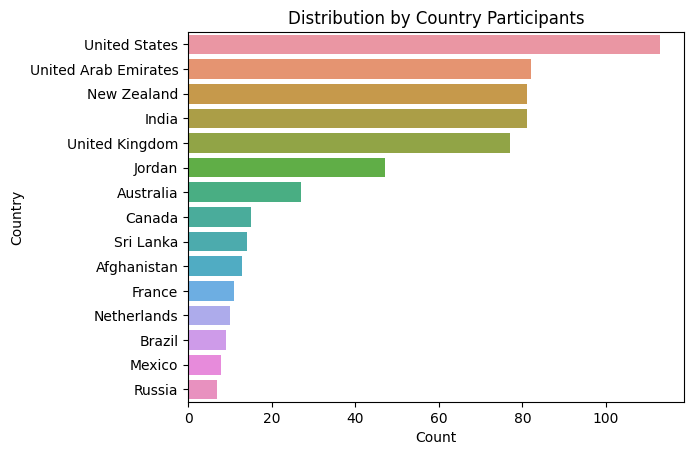

In [63]:
# plot top 15 country participants
fig = sns.barplot(y=autism_screening['contry_of_res'].value_counts().index[:15],
                  x=autism_screening['contry_of_res'].value_counts().values[:15],
                  data=autism_screening)
fig.set(xlabel='Count', ylabel='Country')
plt.title('Distribution by Country Participants')
plt.show()

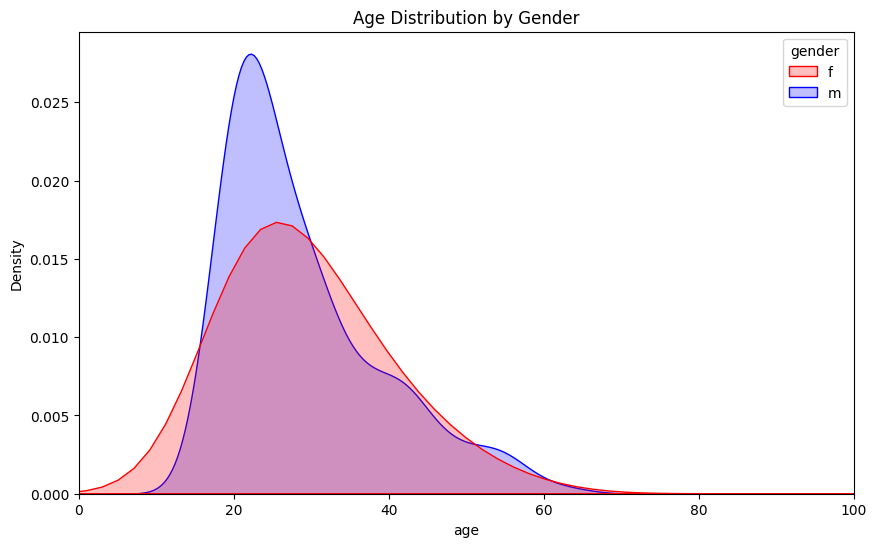

In [64]:
plt.figure(figsize=(10, 6))

# Define the color palette for Gender
palette = {'m': 'blue', 'f': 'red'}

sns.kdeplot(data=autism_screening, x='age', hue='gender', fill=True,
            palette = palette)
plt.title('Age Distribution by Gender')
plt.xlim(0, 100)
plt.show()


#### Preprocessing Pipleline used in each of the models

In [65]:
# Converting all categorical/binary data to numeric
numeric_columns = ["A1_Score", "A2_Score", "A3_Score", "A4_Score", "A5_Score",
                    "A6_Score", "A7_Score", "A8_Score", "A9_Score", "A10_Score",
                    "age", "result"]
categorical_columns = ["gender", "ethnicity", "contry_of_res", "age_desc",
                       "relation"]
binary_columns = ["jundice", "used_app_before"]



# Numeric steps to deal with NaN and scale them
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Binary step to convert yes/no values to 1 or 0
def binary_transform(data):
  return data.replace({"no": 0, "yes": 1}).values.astype(np.float64)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("binary", FunctionTransformer(binary_transform), binary_columns),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
         categorical_columns)
    ])

### Helper functions used for measuring model performance
These functions are used in each of the models to help with calculating performance.

In [66]:
def get_test_train(indicies, X, y):
  """
  Splits the given data matrix and target vector into mutliple
  train/test splits using the given index splits.

  Parameters:
    indicies ([int tuple]): The indices in which to create the train/test splits
                            each fold. These are generated from the split()
                            function of a KFold object
    X (pandas df): The data matrix to split
    y (pandas series or numpy array): The target vector for the data matrix

  Returns:
    A list of tuples for each fold where each tuple contains:
      train_X (pandas df): The data matrix used for training
      train_y (1d): The target vector used for training
      test_X (pandas df): The data matrix used for testing
      test_y (1d array): The target vector used for testing
  """
  result = []
  for train_index, test_index in indicies:
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y[train_index], y[test_index]
    result.append((train_X, train_y, test_X, test_y))

  return result

def convert_scores(scores):
  """
  Converts the given vector of scores containing values of "yes" and "no"
  to contain values of 0 and 1. "yes" is mapped to 1 and "no" is mapped to "0".

  Parameters:
    scores ([str]): The vector to map to 0's and 1's (assumed to contain
                          only values of "no" and "yes")

  Returns:
    int array containing the mapped scores
  """
  return np.array([0 if x == "no" else 1 for x in scores])

def average(list):
  """
  Computes the average of the given list. The given list is assumed to contain
  numbers.

  Parameters:
    list ([float]): The list to get the average of

  Returns:
    The average value of the list
  """
  return sum(list) / len(list)

def report(accuracies, recalls, precisions, f1_scores):
  """
  Prints a report of the given four metrics taken from a series of folds.
  The report contains the average of each of the four scores.

  Parameters:
    accuracies ([float]): A list of all the model accuries in the folds
    recalls ([float]): A list of all the model recalls in the folds
    precisions ([float]): A list of all the model precisions in the folds
    f1_scores ([float]): A list of all the model f1_scores in the folds
  """
  print("--- Model Report ---")
  print(f"Model accuracy: {average(accuracies)}")
  print(f"Model sensitivity: {average(recalls)}")
  print(f"Model precision: {average(precisions)}")
  print(f"Model f1-score: {average(f1_scores)}")


### Decision Tree

#### Creating the Pipeline

In [67]:
# Add the class_weight param since there are many more yes's than no's
pipeline_steps_tree = [
    ("preprocessor", preprocessor),
    ("decision_tree", tree.DecisionTreeClassifier(criterion="entropy",
                                                  class_weight="balanced",
                                                  random_state=44))
]

pipe_tree = Pipeline(pipeline_steps_tree)

#### Grid Search Hyperparameter Tuning

We will be tuning the following hyperparameters for our Decision Tree classifier:

1. `max_depth`: Controls the maximum allowed depth of the tree
2. `min_samples_split`: Controls the number of samples required to split an internal node
3. `max_features`: The number of features to consider when looking for the best split

Additionally, we will be using recall as our scoring mechanism since our main goal is to correctly identify autistic adults as being autistic (we want the smallest amount of false negatives).

In [68]:
# Create a RepeatedKFold object for training/testing splits
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=44)

max_depth_parameters = [None, 1, 2, 5, 10, 15, 25, 50, 75, 100, 150, 200, 300]
min_samples_split_parameters = [2, 5, 10, 20]
max_features_parameters = [None, "sqrt", "log2"]

grid_search_params_tree = {
    "decision_tree__max_depth": max_depth_parameters,
    "decision_tree__min_samples_split": min_samples_split_parameters,
    "decision_tree__max_features": max_features_parameters
}

grid_search_tree = GridSearchCV(pipe_tree,
                                param_grid=grid_search_params_tree,
                                cv=kf,
                                scoring="recall",
                                error_score="raise")

grid_search_tree.fit(X, convert_scores(y))

tuned_params = grid_search_tree.best_params_
best_accuracy = grid_search_tree.best_score_
print(f"Tuned Hyperparameters: {tuned_params}")
print(f"Best score: {best_accuracy}")

Tuned Hyperparameters: {'decision_tree__max_depth': 1, 'decision_tree__max_features': None, 'decision_tree__min_samples_split': 2}
Best score: 0.6690276667776668


#### Measuring model performance and visualizations


##### Setting up

In [69]:
# Note: we use the tuned hyperparameters here
max_depth = tuned_params["decision_tree__max_depth"]
min_samples = tuned_params["decision_tree__min_samples_split"]
max_features = tuned_params["decision_tree__max_features"]
pipeline_steps_tree_tuned = [
    ("preprocessor", preprocessor),
    ("decision_tree", tree.DecisionTreeClassifier(criterion="entropy",
                                                  class_weight="balanced",
                                                  max_depth=max_depth,
                                                  min_samples_split=min_samples,
                                                  max_features=max_features,
                                                  random_state=44))
]

pipe_tree_tuned = Pipeline(pipeline_steps_tree_tuned)

# K-Fold cross-validation
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=44)
indices_tree = [(train_index, test_index) for train_index,
                test_index in kf.split(X)]
splits_tree = get_test_train(indices_tree, X, y)

# Lists to store evaluation metrics for each fold
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Initialize a 2x2 confusion matrix for binary classification
total_cm_tree = np.zeros((2,2))

In [70]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['No Autism', 'Autism'],
                yticklabels=['No Autism', 'Autism'])
    plt.title('Confusion Matrix from One Fold')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

##### Train and evaluate on each fold

In [71]:
# Train and evaluate on each fold
for train_X, train_y, test_X, test_y in splits_tree:
    pipe_tree_tuned.fit(train_X, train_y)

    # Predict on the test data
    predictions = pipe_tree_tuned.predict(test_X)

    # Calculate metrics and add them to the lists
    accuracies.append(accuracy_score(test_y, predictions))
    recalls.append(recall_score(test_y, predictions, pos_label="yes"))
    precisions.append(precision_score(test_y, predictions, pos_label="yes",
                                      zero_division=1))
    f1_scores.append(f1_score(test_y, predictions, pos_label="yes"))

    # Update the confusion matrix
    total_cm_tree += confusion_matrix(test_y, predictions)

In [72]:
# Print average results
report(accuracies, recalls, precisions, f1_scores)

--- Model Report ---
Model accuracy: 0.6460281690140849
Model sensitivity: 0.6690276667776669
Model precision: 0.21849820451657123
Model f1-score: 0.32560888783005576


##### Confusion Matrices

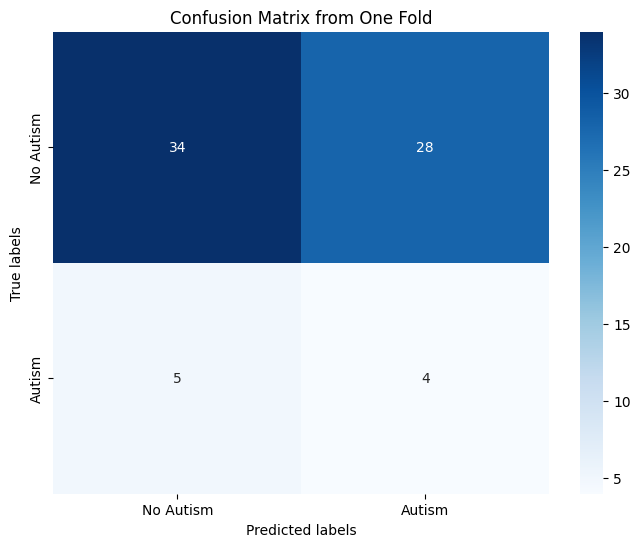

In [73]:
# Let's display the confusion matrix for the first fold, as an example:
train_X, train_y, test_X, test_y = splits_tree[0]  # Taking the first fold
pipe_tree_tuned.fit(train_X, train_y)
predictions = pipe_tree_tuned.predict(test_X)

# Plot the confusion matrix for the first fold
plot_confusion_matrix(test_y, predictions)

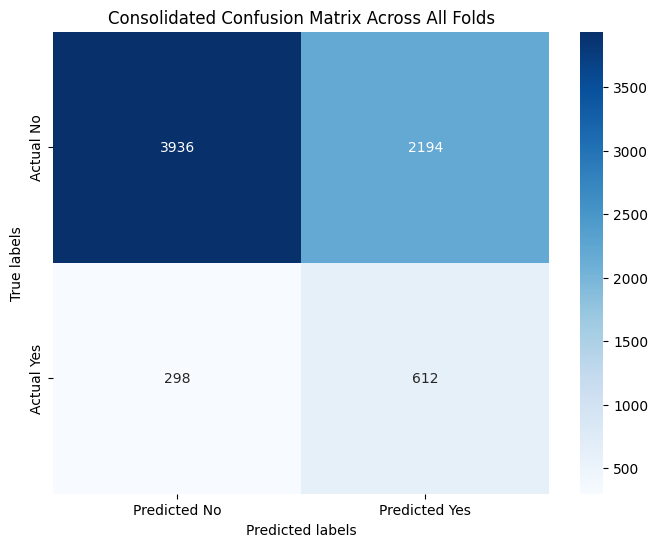

In [74]:
# Plot the consolidated confusion matrix across all the folds
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_tree, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Consolidated Confusion Matrix Across All Folds')
plt.show()

- True Negatives (TN): 3,936
- False Positive (FP): 2194
- False Negative (FN): 298
- True Positive (TP): 612

Our model is good at recognizing the "No" cases, as shown by the high number of correct "No" predictions (true negatives). However, it's not doing well with the "Yes" cases. There aren't relatively many correct "Yes" predictions (true positives), and it often misses them as we can see with the decent amount of false negatives. It seems to favor predicting "No" and struggles to accurately identify "Yes" cases, even after considering the class imbalances in the data.

Plot an example decision tree from the first fold

--- Example Decision Tree from Training ---


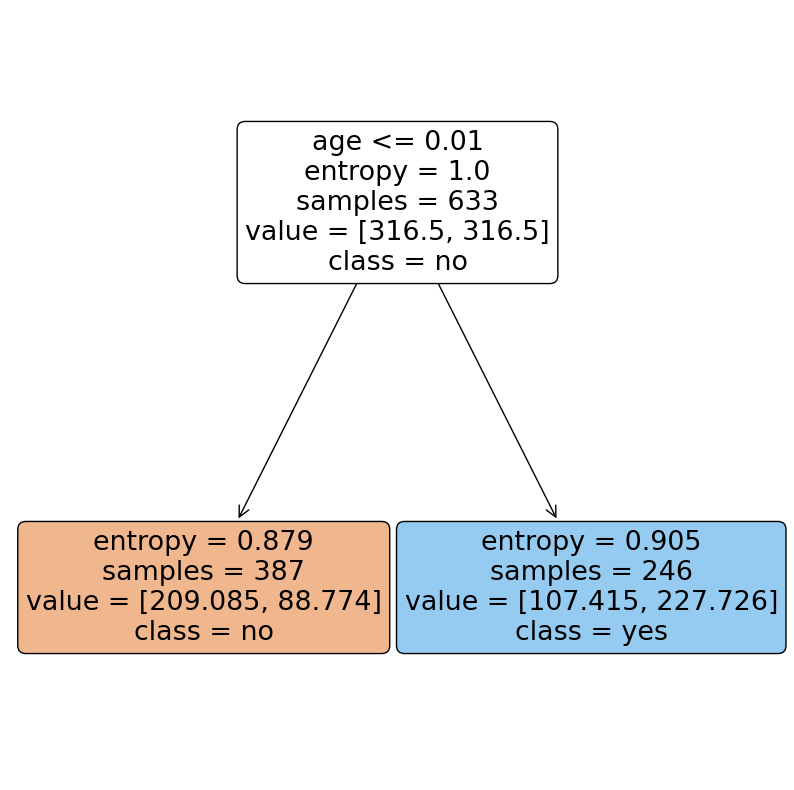

In [75]:
# Plot the decision tree made from model training (first fold)
print("--- Example Decision Tree from Training ---")
plt.figure(figsize=(10, 10))
tree.plot_tree(pipe_tree_tuned['decision_tree'],
               filled=True,
               rounded=True,
               feature_names=X.columns,
               class_names=pipe_tree_tuned['decision_tree'].classes_)
plt.show()

Interestingly, the decision tree seems to only be caring about age, which sheds light on a possible area of research about the impact of age on autism.

### Perceptron

**Create the full pipeline**

In [76]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    # adjust weights inversely proportional to class frequencies
    ("classifier", Perceptron(class_weight='balanced'))
])

**Define Hyperparameters and their possible values**

In [77]:
# Create a StratifiedKFold object for training/testing splits
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=44)

In [78]:
param_grid = {
    "classifier__alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "classifier__max_iter": [500, 1000, 1500],
    "classifier__eta0": [0.1, 0.01, 0.001],
}

In [79]:
# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring="recall")

In [80]:
y_converted = convert_scores(y)
grid_search.fit(X, y_converted)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=44, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['A1_Score',
                                                                          'A2_Score',
                                                                          'A3_Score',
                                                                          'A4_Score',
                                                                          'A5_Score',
                                                                          'A6_Score',
                                                                          'A7_Score',
                                                                          'A8_Score',
                                                                          'A9_Score',
                                                                          'A10_Score',
                                                                          'age',
                                                                          're...
                                                                          'used_app_before']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['gender',
                                                                          'ethnicity',
                                                                          'contry_of_res',
                                                                          'age_desc',
                                                                          'relation'])])),
                                       ('classifier',
                                        Perceptron(class_weight='balanced'))]),
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'classifier__eta0': [0.1, 0.01, 0.001],
                         'classifier__max_iter': [500, 1000, 1500]},
             scoring='recall')

In [81]:
# Print the best parameters and the corresponding accuracy score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation recall: {grid_search.best_score_:.2f}")

Best parameters: {'classifier__alpha': 0.0001, 'classifier__eta0': 0.001, 'classifier__max_iter': 500}
Best cross-validation recall: 0.59


**Measuring model performance and visualizations**

In [82]:
# Extract the best parameters from GridSearchCV
best_alpha = grid_search.best_params_['classifier__alpha']
best_eta0 = grid_search.best_params_['classifier__eta0']
best_max_iter = grid_search.best_params_['classifier__max_iter']

In [83]:
# Create a new Perceptron model with the best parameters
tuned_perceptron = Perceptron(alpha=best_alpha,
                              eta0=best_eta0,
                              max_iter=best_max_iter)

In [84]:
# Create a new pipeline with the tuned Perceptron model
tuned_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", tuned_perceptron)
])

K-Fold cross validation

In [85]:
# K-Fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=44)
indicies = [(train_index, test_index) for train_index,
            test_index in kf.split(X, y)]
splits = get_test_train(indicies, X, y)

# Lists to store evaluation metrics for each fold
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Initialize a 2x2 confusion matrix for binary classification
total_cm = np.zeros((2,2))

Train and evaluate on each fold

In [86]:
# Train and evaluate on each fold
for train_X, train_y, test_X, test_y in splits:
    tuned_pipeline.fit(train_X, train_y)

    # Predict on the test data
    predictions = tuned_pipeline.predict(test_X)

    # Calculate metrics and add them to the lists
    accuracies.append(accuracy_score(test_y, predictions))
    recalls.append(recall_score(test_y, predictions, pos_label="yes"))
    precisions.append(precision_score(test_y, predictions, pos_label="yes",
                                      zero_division=1))
    f1_scores.append(f1_score(test_y, predictions, pos_label="yes"))

    # Update the confusion matrix
    total_cm += confusion_matrix(test_y, predictions)

In [87]:
# Print average results
report(accuracies, recalls, precisions, f1_scores)

--- Model Report ---
Model accuracy: 0.7998993963782695
Model sensitivity: 0.13999999999999999
Model precision: 0.30974025974025976
Model f1-score: 0.13130533149714735


Perceptron model seems to have difficulty correctly predicting the positive class ("yes"). This could be due to class imbalance.

# Visualizations

**Confusion Matrix**

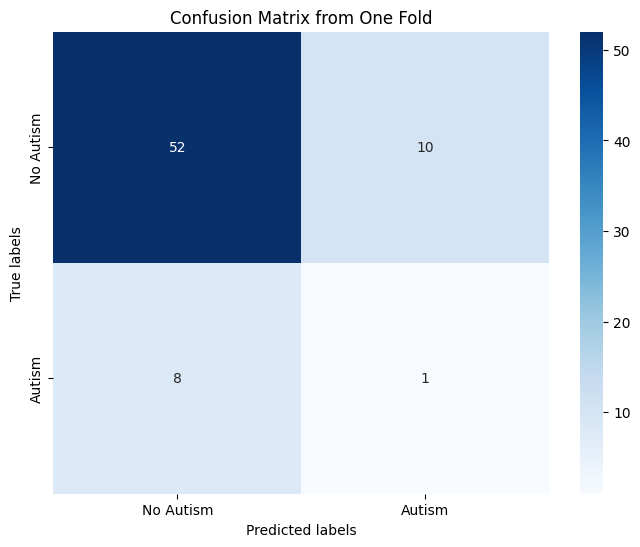

In [88]:
# Let's display the confusion matrix for the first fold, as an example:
train_X, train_y, test_X, test_y = splits[0]  # Taking the first fold
tuned_pipeline.fit(train_X, train_y)
predictions = tuned_pipeline.predict(test_X)

# Plot the confusion matrix for the first fold
plot_confusion_matrix(test_y, predictions)

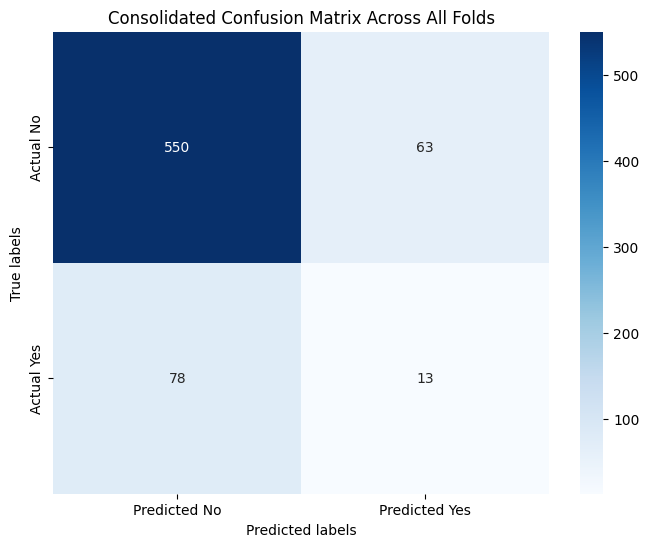

In [89]:
# Plot the consolidated confusion matrix across all the folds
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Consolidated Confusion Matrix Across All Folds')
plt.show()

- True Negatives (TN): 550
- False Positive (FP): 63
- False Negative (FN): 78
- True Positive (TP): 13

Our model has a high number of true negatives, which means it's doing well at identifying the "No" class. The number of true positives is low compared to the false negatives. This means the model is often missing the positive instances ("Yes"), consistent with low recall value. The number of false positives is also significant. This means, when our model predicts "Yes", it's often wrong, consistent with the low precision value. The model seems to be biased towards predicting the "No" class and has difficulty correctly identifying the "Yes" class even after accouting for class imbalance.

In [90]:
print(y.value_counts())

no     613
yes     91
Name: austim, dtype: int64


### Logistic Regression

Creating the Pipeline and initializing Hyperparamters to tune

In [91]:
pipeline_log_reg = [
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", random_state=44))
]

pipe_log_reg = Pipeline(pipeline_log_reg)


In [92]:
log_kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=44)
param_grids = {
    'model__C' : np.logspace(-4, 4, 20),
    'model__max_iter' : [100, 1000, 2500, 5000],
    'model__solver' : ['liblinear', 'saga'],
    'model__penalty' : ['l1', 'l2']
}


grid_search_logreg =  GridSearchCV(estimator=pipe_log_reg,
                                   param_grid=param_grids,
                                   cv = kf,
                                   scoring = 'recall')
grid_search_logreg.fit(X, convert_scores(y))


tuned_params = grid_search_logreg.best_params_
best_accuracy = grid_search_logreg.best_score_
print(f"Tuned Hyperparameters: {tuned_params}")
print(f"Best score: {best_accuracy}")

Tuned Hyperparameters: {'model__C': 0.03359818286283781, 'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best score: 0.69


Use Tuned Parameters to Create New Pipeline for the Best Model Performance

In [93]:
tuned_logisitic = LogisticRegression(penalty = 'l1',
                                     class_weight="balanced",
                                     C = 0.03359818286283781,
                                     random_state = 44,
                                     max_iter= 100,
                                     solver = 'liblinear')

tuned_pipeline_log_reg = [
    ("preprocessor", preprocessor),
    ("model", tuned_logisitic)
]

tuned_pipe_log_reg = Pipeline(tuned_pipeline_log_reg)


In [94]:
# K-Fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=44)
indices = [(train_index, test_index) for
           train_index, test_index in kf.split(X, y)]
splits_log = get_test_train(indices, X, y)

In [95]:
# Lists to store evaluation metrics for each fold
accuracies = []
recalls = []
precisions = []
f1_scores = []

# Initialize a 2x2 confusion matrix for binary classification
cm = np.zeros((2,2))

In [96]:
# Train and evaluate on each fold
for train_X, train_y, test_X, test_y in splits_log:
    tuned_pipe_log_reg.fit(train_X, train_y)

    # Predict on the test data
    predictions = tuned_pipe_log_reg.predict(test_X)

    # Calculate metrics and add them to the lists
    accuracies.append(accuracy_score(test_y, predictions))
    recalls.append(recall_score(test_y, predictions, pos_label="yes"))
    precisions.append(precision_score(test_y, predictions, pos_label="yes",
                                      zero_division=1))
    f1_scores.append(f1_score(test_y, predictions, pos_label="yes"))

    # Update the confusion matrix
    cm += confusion_matrix(test_y, predictions)

In [97]:
# Print average results
report(accuracies, recalls, precisions, f1_scores)

--- Model Report ---
Model accuracy: 0.5667203219315895
Model sensitivity: 0.69
Model precision: 0.18391007976047422
Model f1-score: 0.2901339466312144


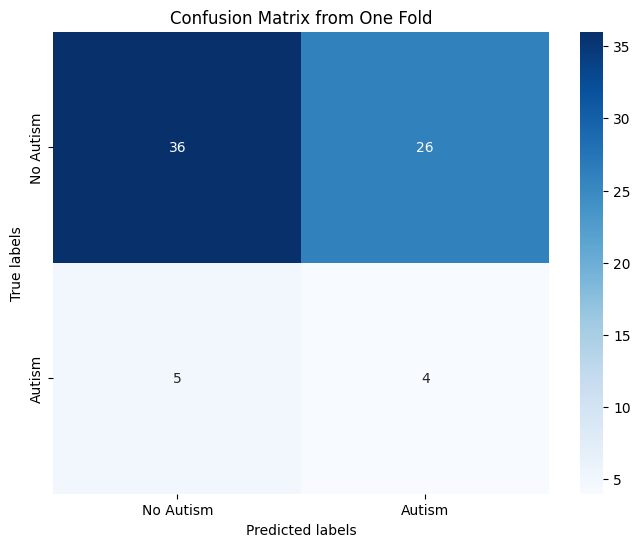

In [98]:
# Let's display the confusion matrix for the first fold, as an example:
train_X, train_y, test_X, test_y = splits_log[0]  # Taking the first fold
tuned_pipe_log_reg.fit(train_X, train_y)
predictions = tuned_pipe_log_reg.predict(test_X)

# Plot the confusion matrix for the first fold
plot_confusion_matrix(test_y, predictions)

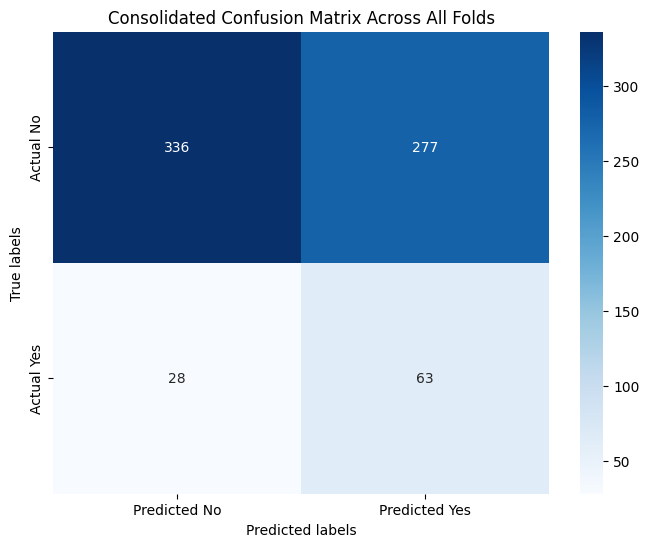

In [99]:
# Plot the consolidated confusion matrix across all the folds
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Consolidated Confusion Matrix Across All Folds')
plt.show()

- True Negatives (TN): 336
- False Positive (FP): 277
- False Negative (FN): 28
- True Positive (TP): 63

This Logisitic Regression model performs very well when it is predicting 'No' cases as it has a high true negative value with relatively low false negatives. However, the model has a difficult time predicting the 'Yes' cases as there is a higher number of false positives than true positives, meaning the model has a better chance of misclassifying. One possible reason that the model is performing so poorly in terms of the 'Yes' cases would be because the data that the model is working off of. There is an imbalance in the dataset as there were a lot more people who did not show any signs of autism and the people who did. If there isn't much data about people who did show signs of autism then poor performance from the model isn't too suprising.